# Predicting Crowdedness at the Gym

In this project a dataset about *Crowdedness at the Campus Gym* is given to predict times where the gym is least crowded. The machine learning algorithm that should be used is linear regression with stochastic gradient descent.

First the necessary libraries are imported and the dataset is read in:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('crowdness_gym_data.csv')
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [2]:
df.shape

(62184, 11)

The dataset contains `11` features and `62184` observations. The features are described by:

- `number_people`: number of people at the gym at each observation (used as target variable or label)
- `date`: specific date and time information
- `timestamp`: number of seconds since the start of the day (00:00)
- `dayofweek`: 0 is equal to Monday and 6 is equal to Sunday
- `is_weekend`: definition if this observation happened during a weekend (1 for yes, 0 for no)
- `is_holiday`: definition if the observation happened during a holiday (1 for yes, 0 for no)
- `temperature`: temperature during the day of the observation (Fahrenheit)
- `isstartof_semester`: definition if the observation happened in the first 2 weeks of a semester (1 for yes, 0 for no)
- `is_during_semester`: definition if the observation happened during the active semester (1 for yes, 0 for no)
- `month`: month of the year (1 is equal to January, 12 is equal to December)
- `hour`: hour of the day (0 to 23)

## Exploring and Cleaning the Data

Except for the year, the information in `date` is already included in other features of the dataset. Since the goal of this project is prediction, differences regarding the year are not of interest. Consequently, `date` can be dropped:

In [3]:
df.drop(labels='date',axis=1,inplace=True)

Similarly, `hour` is included in `timestamp`.

There are no missing values in the dataset:

In [4]:
df.isna().sum()

number_people           0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

Minimum and maximum values lie in a reasonable range and the distributions are not significantly skewed:

In [5]:
df.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


The *pearson* correlations in the dataset is given by:

<AxesSubplot:>

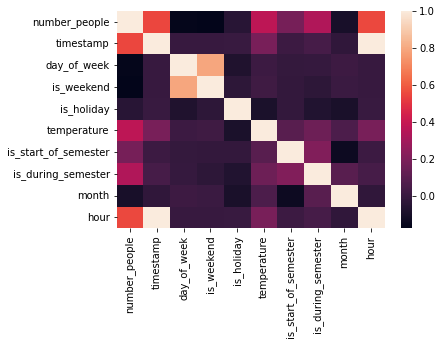

In [6]:
pearsons = df.corr()
plt.figure(figsize=(6,4))
sns.heatmap(pearsons)

A better observability is given by restricting the output to a threshold of 0.3:

<AxesSubplot:>

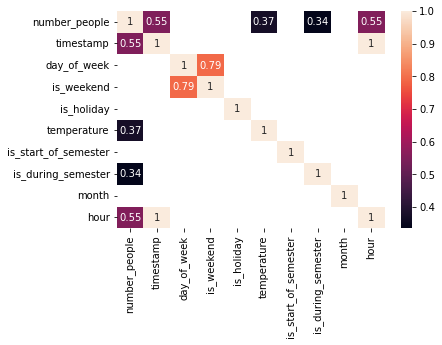

In [7]:
plt.figure(figsize=(6,4))
sns.heatmap(pearsons[abs(pearsons) > 0.3],annot=True)

`temperature` and `is_during_semester` are reasonable and `timestamp` and `hour` are strongly correlated with `number_people`. The latter is indicating that `timestamp` is not giving any new information in comparison to `hour`.

## Building the Model

Based on these obervations, the features `temperature`, `is_during_semester` and `hour` are used for training the model. The size of the test set is set to be `20%` of the original dataset:

In [8]:
X = df[['temperature','is_during_semester','hour']]
y = df['number_people']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Since the features are on a different scale they are standardized:

In [9]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The model is build and fitted:

In [10]:
model = SGDRegressor(tol=1e-4,eta0=1e-4,max_iter=10000)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

## Results

A metric for the prediction quality is the root mean squared error which is given by:

In [11]:
rmse = mean_squared_error(y_test,y_pred,squared=False)
print(rmse)

16.65466476767749


On average the data is predicted incorrectly by `16.7` people. Given a mean of `29` people this error is significant.

A visual representation of the prediction quality is given in the following by plotting the original data (blue in background) versus the predicted data (orange in foreground):

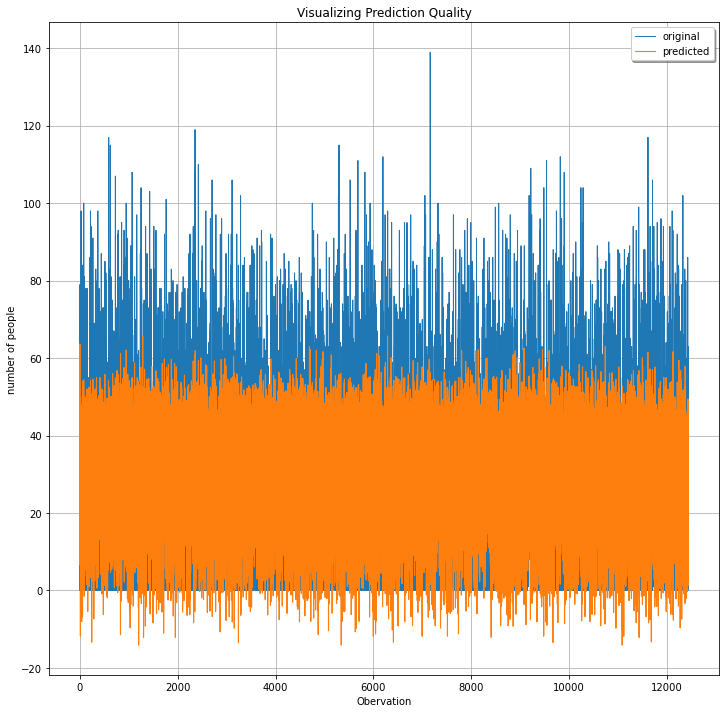

In [12]:
plt.figure(figsize=(12, 12))

x_ax = range(len(y_test))
plt.plot(x_ax,y_test,linewidth=1,label="original")
plt.plot(x_ax,y_pred,linewidth=1.1,label="predicted")
plt.title("Visualizing Prediction Quality")
plt.xlabel('Obervation')
plt.ylabel('number of people')
plt.legend(loc='best',fancybox=True,shadow=True)
plt.grid(True)
plt.show() 

As described before the data matches only moderately. In particular observations with a high number of people are not predicted appropriately. Furthermore, there are predictions with a negative number of people. This indicates problems in the fundamental assumptions of linear regression. 

Nonetheless, for a first approach in a machine learning workflow, the presented method shows a reasonable and comprehensible prediction for the dataset given.